In [1]:
import pandas as pd
import numpy  as np
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter("ignore")
hfont = {'fontname':'Monaco'}
hfont = {'fontsize':'24'}

# Making the plots standard 
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 5]

In [2]:
#import the training and test pickles 
train_df = pd.read_pickle('train_df.pickle')
test_df = pd.read_pickle('test_df.pickle')

#get the training std 
trainrtt_mean = train_df['last_rtt'].mean()
trainrtt_std = train_df['last_rtt'].std()

In [3]:
# Choose your features and target
X_train = train_df['normalizzed_distance'].values.reshape(-1,1)
y_train = train_df['normalizzed_rtt'].values
        
X_test = test_df['normalizzed_distance'].values.reshape(-1,1)
y_test = test_df['normalizzed_rtt'].values

In [4]:
# SIMPLE LINEAR REGRESSION MODEL
# https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python
# using a simple linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train a linear regression model
model = LinearRegression()

model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print evaluation metrics
sample_size = len(y_test)
numerator_rmse = abs(y_pred - y_test)**2 
numerator_std = abs(y_pred - y_test.mean())**2
denominator = sample_size - 1

#loss function for linear regression
rmse_lm = np.sqrt(mean_squared_error(y_test, y_pred))
drmse_lm = rmse_lm * trainrtt_std
print(f'RMSE for Linear Regression: ', rmse_lm, 'denormalised rmse linear regression: ', drmse_lm)

RMSE for Linear Regression:  0.4013904992520766 denormalised rmse linear regression:  3.7498107782511725


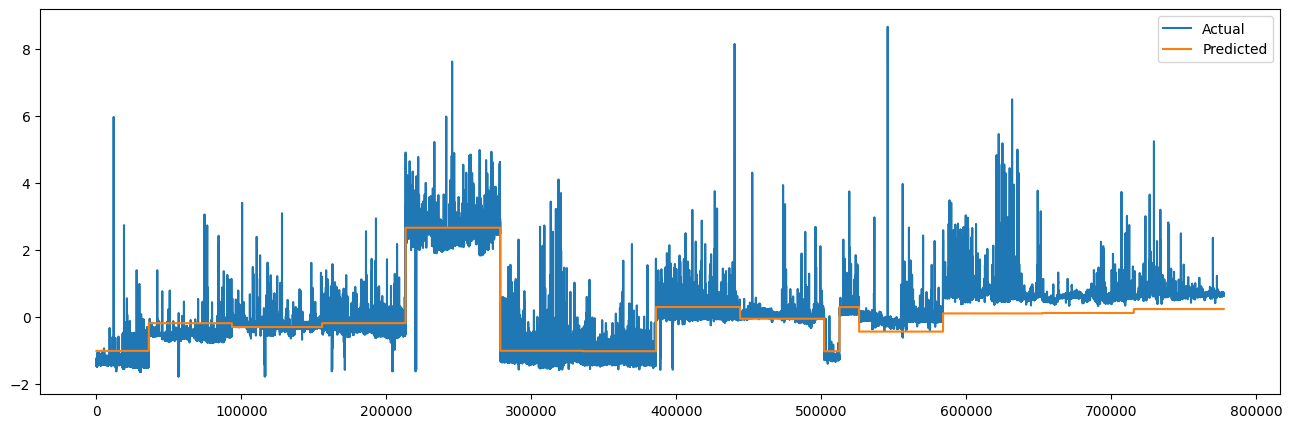

In [5]:
#p;ot the predictions against the actual values
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()

In [6]:
#DECISION TREE REGRESSION
# Using a decison tree regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Create a linear regression model
dt_model = DecisionTreeRegressor(
    criterion='squared_error',  # This is the function used to measure the quality of a split (Mean Squared Error)
    splitter='best',  # Strategy used to split at each node. 'best' finds the best split, 'random' selects random.
    max_depth=None,   # The maximum depth of the tree. None means nodes are expanded until all leaves are pure.
    random_state=42   # Seed used by the random number generator for randomness. Setting this ensures reproducibility.
)

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = dt_model.predict(X_test)

# Evaluate the model
sample_size = len(y_test)
numerator = abs(y_pred - y_test)**2
denominator = sample_size - 1

#loss function for decision tree
rmse_dt = np.std(y_pred)
drmse_dt = rmse_dt * trainrtt_std
print(f'RMSE for Decision Tree: ', {rmse_dt}, 'denormalised rmse: ', {drmse_dt})


RMSE for Decision Tree:  {0.975715258634999} denormalised rmse:  {9.115182347741433}


In [7]:
#RANDOM FOREST REGRESSION
# Using a random forest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree,export_text

# create an instance of the regression tree model and set the hyperparameters 

rand_forest = RandomForestRegressor(
    n_estimators=10 ,  # The number of trees in the forest.
    criterion='squared_error',   # This is the function used to measure the quality of a split (Mean Squared Error)
    max_depth=None,    # The maximum depth of the trees. None means nodes are expanded until all leaves are pure.
    random_state=42,    # Seed used by the random number generator for randomness.
    max_leaf_nodes=None,   # Grow trees with max_leaf_nodes in best-first fashion.
    min_impurity_decrease=0.0,   # A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
    bootstrap=True,  # Whether bootstrap samples are used when building trees.
    oob_score=False,  # Whether to use out-of-bag samples to estimate the generalization accuracy.
    n_jobs=None,   # The number of jobs to run in parallel for both fitting and predicting.
)

# fit the model to the training data
rand_forest.fit(X_train, y_train)

# make predictions on the testing data
y_pred = rand_forest.predict(X_test)

#loss function for the random forest regressor
sample_size = len(y_test)
numerator = abs(y_pred - y_test)**2
denominator = sample_size - 1

#loss function for random forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
drmse_rf = rmse_rf * trainrtt_std
print(f'RMSE for Random Forest: ', rmse_rf, 'Denormalised rmse rf: ', drmse_rf)

RMSE for Random Forest:  0.21903994551749326 Denormalised rmse rf:  2.0462824857576556


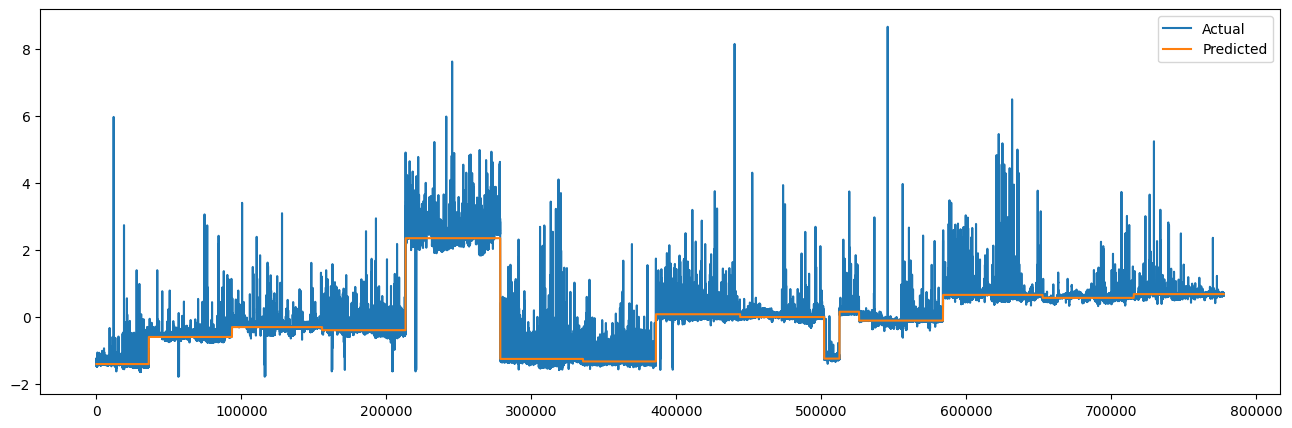

In [8]:
#plot actual vs predicted values
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()


In [9]:
#XGBOOST REGRESSION
# https://www.kaggle.com/code/carlmcbrideellis/an-introduction-to-xgboost-regression
# https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
# https://stackoverflow.com/questions/62176516/how-to-visualize-an-xgboost-tree-from-gridsearchcv-output#62178005

# Using a xgboost regressor
from xgboost import XGBRegressor, plot_tree
from sklearn.model_selection import GridSearchCV
regressor= XGBRegressor()

# exhaustively search for the optimal hyperparameters
param_grid = {"max_depth":    [4, 5, 6],
            "n_estimators": [50, 60, 70],
            "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
grid_search = GridSearchCV(regressor, param_grid).fit(X_train, y_train)

print("The best hyperparameters are ",grid_search.best_params_)


The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 6, 'n_estimators': 70}


In [10]:
regressor=XGBRegressor(learning_rate = grid_search.best_params_["learning_rate"],
                        n_estimators  = grid_search.best_params_["n_estimators"],
                        max_depth     = grid_search.best_params_["max_depth"],
                        objective     = 'reg:squarederror')
                        


regressor.fit(X_train, y_train)
regressor.get_booster().feature_names = ['normalized_distance']
y_pred = regressor.predict(X_test)

# Calculate the mean squared error
sample_size = len(y_test)
numerator = abs(y_pred - y_test)**2
denominator = sample_size - 1
xgb_std = np.std(y_pred)

xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_drmse = xgb_rmse * trainrtt_std
print(f'RMSE for XGBoost: ', xgb_rmse, 'Denormalised RMSE: ', xgb_drmse)

RMSE for XGBoost:  0.43915481820037516 Denormalised RMSE:  4.102606996620839


In [11]:
#KNN REGRESSION
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Create an instance of the KNN regressor
knn = KNeighborsRegressor(n_neighbors=5,weights='distance')

# Fit the model on the training data
knn.fit(X_train, y_train)

# Make a prediction on the testing data
y_pred = knn.predict(X_test)

# Evaluate the model using mean squared error
sample_size = len(y_test)
numerator = abs(y_pred - y_test)**2
denominator = sample_size - 1
knn_std = np.std(y_pred)

knn_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
knn_drmse = knn_rmse * trainrtt_std
print(f'RMSE for KNN: ', knn_rmse, 'Denormalised RMSE: ', knn_drmse)

RMSE for KNN:  0.2274757015619291 Denormalised RMSE:  2.1250897544824134


In [12]:
#LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM , Flatten
import os
os.environ['TF_METAL_DEVICE'] = '1'

In [13]:
# split a univariate sequence into samples
from numpy import array

def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
    # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return array(X)

n_steps = 100

Xtrain_3d = split_sequence(X_train[:1000],n_steps)
Xtest_3d = split_sequence(X_test[:1000],n_steps)
Xtrain_3d.shape

(900, 100, 1)

In [14]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
Xtrain_3d  = Xtrain_3d .reshape((Xtrain_3d.shape[0], Xtrain_3d.shape[1], n_features))
Xtest_3d = Xtest_3d .reshape((Xtest_3d.shape[0], Xtest_3d.shape[1], n_features))
Xtrain_3d[0].shape

(100, 1)

In [15]:
# define model

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [16]:
# fit model
model.fit(Xtrain_3d,y_train[0:len(Xtrain_3d)],epochs=20, verbose=0)

In [17]:
y_pred = model.predict(Xtest_3d, verbose=0)

#loss function for LSTM
lstm_rmse = np.sqrt(mean_squared_error(y_test[0:len(y_pred)], y_pred))
lstm_drmse = lstm_rmse * trainrtt_std

print(f'RMSE for LSTM: ', lstm_rmse, 'Denormalied RMSE: ', lstm_drmse)


RMSE for LSTM:  0.04975639936721412 Denormalied RMSE:  0.4648268531063994


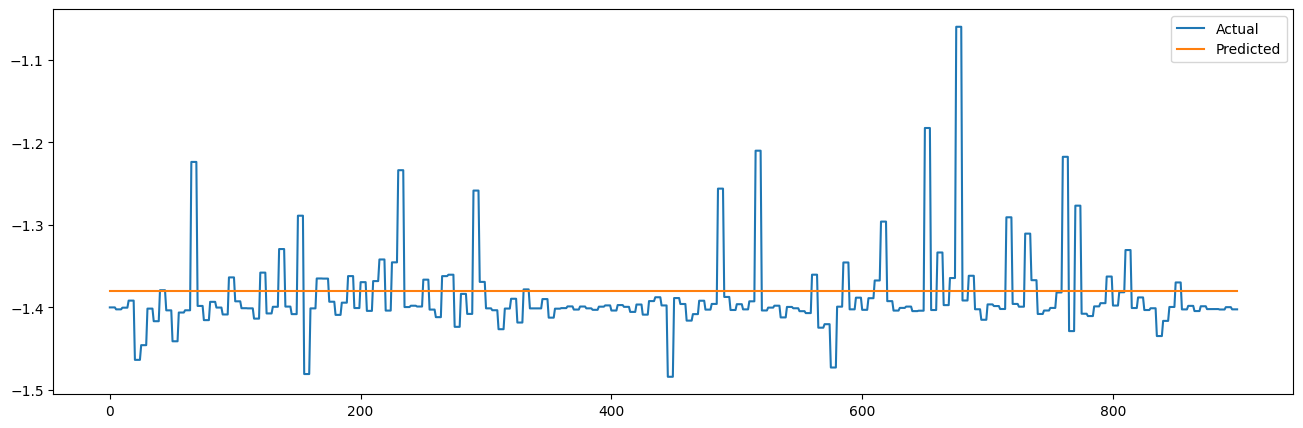

In [18]:
#plot actual vs predicted values
plt.plot(y_test[0:len(y_pred)], label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [19]:
#SUPPORT VECTOR REGRESSION
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Create a linear SVR
regressor = SVR(kernel='linear')

# Train a  regressor
regressor.fit(X_train[:1000], y_train[:1000])

# Make predictions on the test set using the trained regressor
y_pred = regressor.predict(X_test)

# Calculate the loss function
svr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
svr_drmse = svr_rmse * trainrtt_std
print(f'RMSE for SVR: ', svr_rmse, 'Denormalised rmse: ', svr_drmse)

RMSE for SVR:  1.6703096072902948 Denormalised rmse:  15.604118632863297


In [20]:
# Using Prophet for time series forecasting
# https://www.youtube.com/watch?v=j_KuqOktXZM&list=PL6UJrXaOPPcEesMFPaieQJwnBvKiRH2tT&index=2
# https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html
from prophet import Prophet 
from sklearn.metrics import mean_squared_error

# collect the data for Prophet
train_prophet_df = train_df[['date','normalizzed_rtt']]
test_prophet_df = test_df[['date','normalizzed_rtt']]
train_prophet_df.columns = ['ds','y']
test_prophet_df.columns = ['ds','y']

# create a Prophet model
model = Prophet()

# fit the model to the data
model.fit(train_prophet_df)

# make predictions for the future dates
forecast = model.predict(test_prophet_df)

# calculate the mean squared error and standard deviation
sample_size = len(y_test)
numerator = abs(forecast['yhat'] - y_test)**2 
denominator = sample_size - 1

#loss function for Prophet
rmse_prophet = np.sqrt(mean_squared_error(y_test, forecast['yhat']))
drmse_prophet = rmse_prophet * trainrtt_std
print(f'RMSE for Prophet: ', rmse_prophet, 'denormalised rmse: ', drmse_prophet)

11:55:58 - cmdstanpy - INFO - Chain [1] start processing
11:56:29 - cmdstanpy - INFO - Chain [1] done processing


RMSE for Prophet:  0.9960448584062394 denormalised rmse:  9.305102518950706


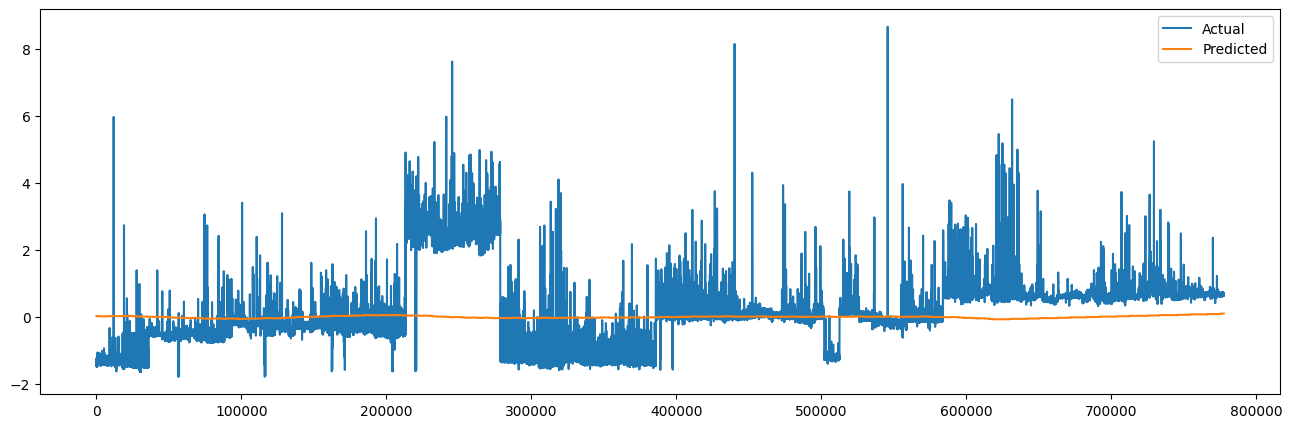

In [21]:
#plot the actual and predicted values
plt.plot(y_test, label='Actual')
plt.plot(forecast['yhat'], label='Predicted')
plt.legend()
plt.show()

In [22]:
# NAIVE APPROACH
# Using the naive forecast
test_df = test_df.assign(naive=test_df['normalizzed_rtt'].shift(1)) # next sample is the previous one

# Replace NaN at top of value column with 0
test_df['naive'] = test_df['naive'].fillna(method='ffill').fillna(0)

# Testing the prediction accuracy for naive forecast
rmse_naive = np.sqrt(mean_squared_error(test_df['normalizzed_rtt'], test_df['naive']))
drmse_naive = rmse_naive * trainrtt_std

#output the results
print(f"Root Mean Squared Error and denormalised rmse for naive method: {rmse_naive,drmse_naive}")

Root Mean Squared Error and denormalised rmse for naive method: (0.09160940498334531, 0.8558197935322649)


In [23]:
#EXPONENTIAL SMOOTHING  - Simple Exponential Smoothing
# https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting 
# https://grisha.org/blog/2016/02/16/triple-exponential-smoothing-forecasting-part-ii/
# https://grisha.org/blog/2016/02/17/triple-exponential-smoothing-forecasting-part-iii/
from statsmodels.tsa.api import SimpleExpSmoothing

fit1 = SimpleExpSmoothing(test_df['normalizzed_rtt']).fit()
test_df['Simple-smoothing'] = SimpleExpSmoothing(test_df['normalizzed_rtt']).fit().fittedvalues

rmse_esm = np.sqrt(mean_squared_error(test_df['normalizzed_rtt'], test_df['Simple-smoothing']))
drmse_esm = rmse_esm * trainrtt_std

print(f"Root Mean Squared Error and denormalised rmse: {rmse_esm,drmse_esm}")

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Root Mean Squared Error and denormalised rmse: (0.09159563667398046, 0.8556911692749622)


In [24]:
#EXPONENTIAL SMOOTHING  - Double Exponential Smoothing
from statsmodels.tsa.api import Holt

# Specify your own values for alpha and beta
alpha_value = 0.6
beta_value = 0.2

# Fitting (adjusting) the data to Holt's linear method with specified alpha and beta
fit2 = Holt(test_df['normalizzed_rtt']).fit()
test_df['Double-smoothing'] = Holt(test_df['normalizzed_rtt']).fit(smoothing_level=alpha_value, smoothing_slope=beta_value).fittedvalues

# Testing the prediction accuracy for Holt's linear method
se = (test_df['normalizzed_rtt'] - test_df['Double-smoothing']) ** 2
mse_desm = se.mean()

# Print the root Mean Squared Error for Holt's linear method
rmse_desm = np.sqrt(mean_squared_error(test_df['normalizzed_rtt'], test_df['Double-smoothing']))
drmse_desm = rmse_desm * trainrtt_std
print(f"Root Mean Squared Error and denormalised rmse: {rmse_desm,drmse_desm}")

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


Root Mean Squared Error and denormalised rmse: (0.1054344028088846, 0.9849736373629071)


In [25]:
test_df[['normalizzed_rtt','naive','Simple-smoothing']]

,normalizzed_rtt,naive,Simple-smoothing
0,-1.399992,0.000000,-1.399992
1,-1.399992,-1.399992,-1.399992
2,-1.399992,-1.399992,-1.399992
3,-1.399992,-1.399992,-1.399992
4,-1.399992,-1.399992,-1.399992
...,...,...,...
1238885,0.687880,0.687880,0.687880
1238886,0.687880,0.687880,0.687880
1238887,0.687880,0.687880,0.687880
1238888,0.687880,0.687880,0.687880
